# Advanced Lane Finding

Advanced lane finding based on the project lessons

   The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

    


In [1]:
## import packages
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import glob
import cv2
import os

%matplotlib inline
warnings.simplefilter('ignore')

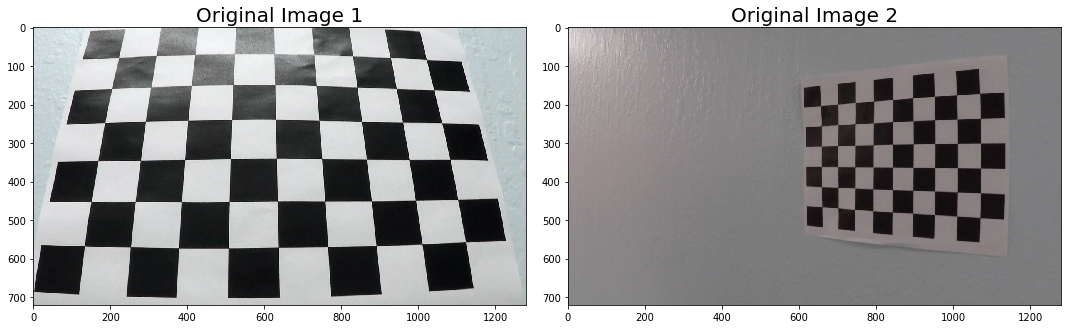

In [43]:
# Cal the Camera

## setting camera calibration image path
CAM_CAL_IMG_PATH = "camera_cal/"

## read in the list of calibration images
camera_cal_list = os.listdir(CAM_CAL_IMG_PATH)
camera_cal_list = [CAM_CAL_IMG_PATH+imname for imname in camera_cal_list if imname != ".DS_Store"]

## show one of the calibration images
camera_cal_img_0 = cv2.imread(camera_cal_list[1])
camera_cal_img_1 = cv2.imread(camera_cal_list[9])

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(camera_cal_img_0)
ax1.set_title('Original Image 1', fontsize=20)

ax2.imshow(camera_cal_img_1)
ax2.set_title('Original Image 2', fontsize=20)

## Calibration Helper Functions

Have not finished this. and have not implimented in code. 

In [48]:
# function for finding corners
def findCorners(img, nx=9, ny=6, draw=True):

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if found, draw corners
    if ret == True:
        # Draw and display the corners
        if draw:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        return corners

# function for undistorting calibration images
def cal_and_undistort(img, objpoints_mat, imgpoints_mat):

    # use cv2.calibrateCamera() to calculate the data necessary for undistorting an image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_mat, imgpoints_mat, img.shape[0:2], None, None)
    
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist


## Calibrate Camera 

(720, 1280, 3)


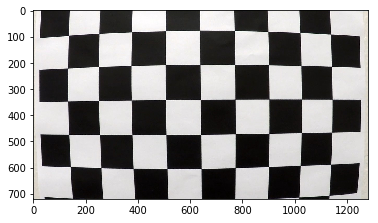

In [45]:
# View Camera image data
img = mpimg.imread('camera_cal/calibration1.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

### Extract object points and image points for camera calibration

In [49]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

images = glob.glob("camera_cal/calibration*.jpg")

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

### Calibrate, calculate distortion coefficients, and test undistortion on an image

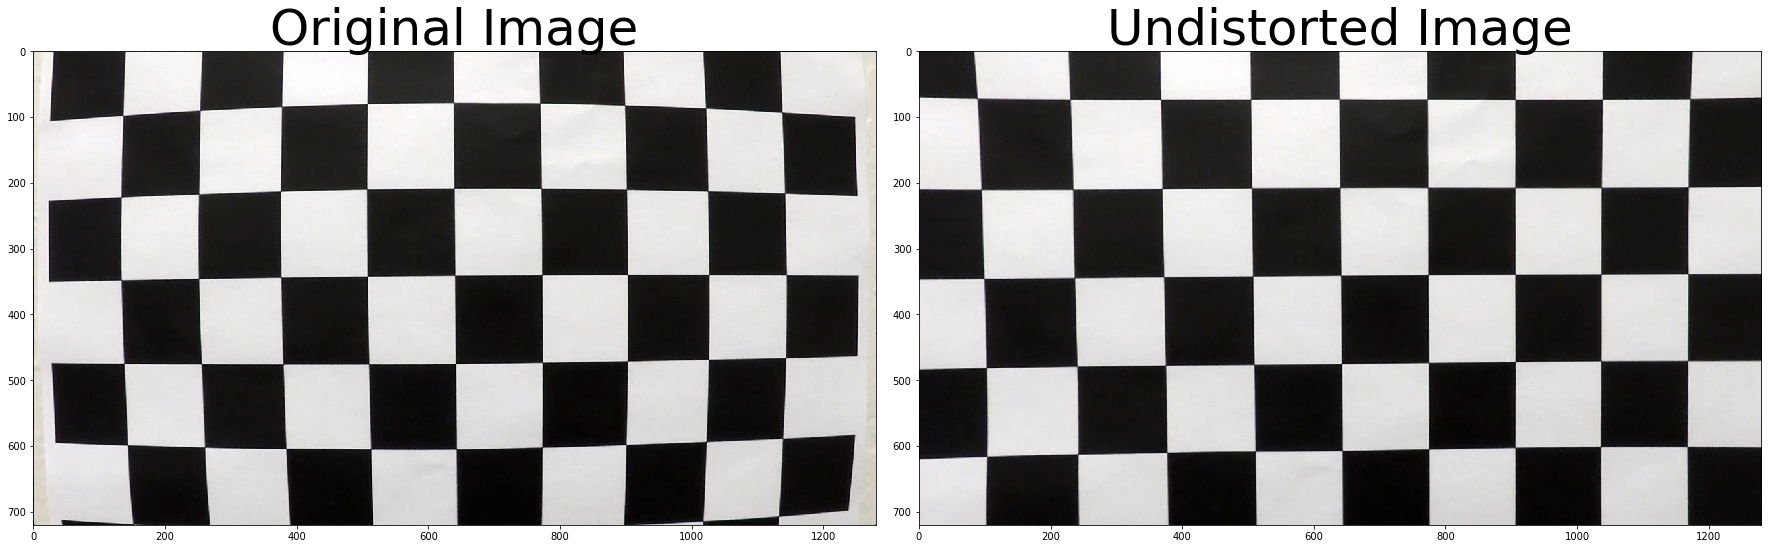

In [50]:
# Distortion Correction
img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted = cal_and_undistort(img, objpoints, imgpoints)

# Plot Images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save image for write up
#f.savefig("output_images/orig_distorted_img.png")


### Test Cal and undistort on sample road images



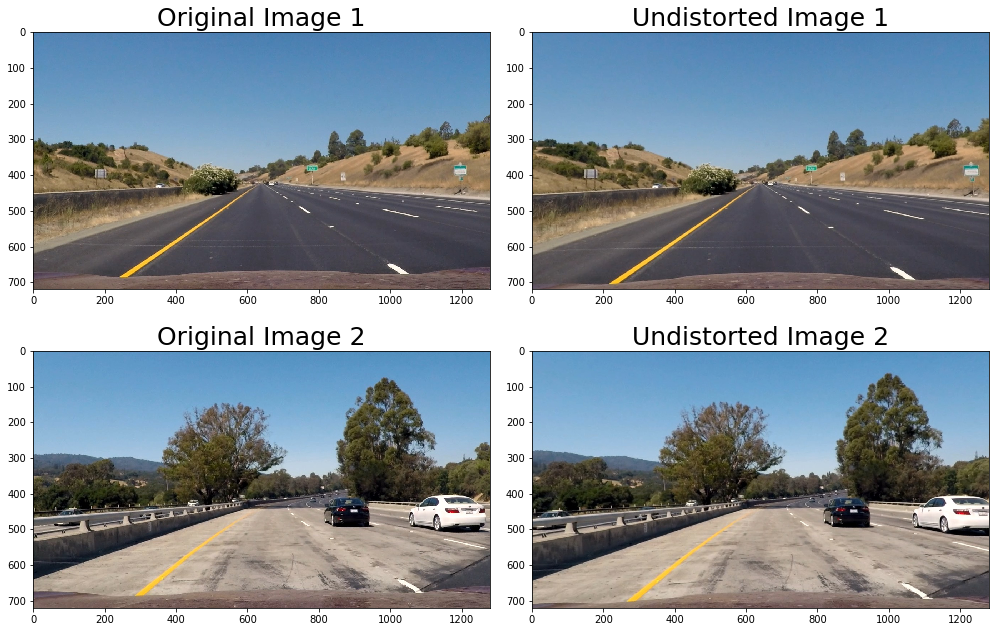

In [52]:
# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
undistort_1 = cal_and_undistort(straight_lines1, objpoints, imgpoints)
undistort_2 = cal_and_undistort(test1, objpoints, imgpoints)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
f.tight_layout()

ax1.imshow(straight_lines1)
ax1.set_title('Original Image 1', fontsize=25)
ax2.imshow(undistort_1)
ax2.set_title('Undistorted Image 1', fontsize=25)

ax3.imshow(test1)
ax3.set_title('Original Image 2', fontsize=25)
ax4.imshow(undistort_2)
ax4.set_title('Undistorted Image 2', fontsize=25)


# Save image for write up
#f.savefig("output_images/undistort_road_img_sample.png")

In [53]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test1.shape[0:2], None, None)

# Pipeline Helper Functions

In [54]:
# raw image undistortion
def undistort_img(img, camera_matrix=mtx, distortion_matrix=dist):

    # using OpenCV's undistortion as before
    undist_img = cv2.undistort(img, camera_matrix, distortion_matrix, None, camera_matrix)
    
    return undist_img

# use sobel thresholding to image
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel)
    
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    
    # create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# magnitude of gradient thresholding
def magnitude_thresh(img, sobel_kernel=3, mag_thresh_input=(0, 255)):
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the magnitude 
    sobelxy_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelxy_scaled = np.uint8(255*sobelxy_mag/np.max(sobelxy_mag))
    
    # create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobelxy_scaled)
    binary_output[(sobelxy_scaled >= mag_thresh_input[0]) & (sobelxy_scaled <= mag_thresh_input[1])] = 1
    
    return binary_output

# direction of gradient thresholding
def direction_thresh(img, sobel_kernel=3, dir_thresh_input=(0, np.pi/2)):
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    # create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= dir_thresh_input[0]) & (dir_grad <= dir_thresh_input[1])] = 1
    
    return binary_output

def combined_thresh(img, sobel_thresh=(20,100), sobel_kernel=3, 
                         mag_thresh=(30,100), dir_thresh=(0.7, 1.3)):
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output_sobel = np.zeros_like(scaled_sobel)
    binary_output_sobel[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    
    # calculate the magnitude 
    sobelxy_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelxy_scaled = np.uint8(255*sobelxy_mag/np.max(sobelxy_mag))
    
    # create a binary mask where mag thresholds are met
    binary_output_mag = np.zeros_like(sobelxy_scaled)
    binary_output_mag[(sobelxy_scaled >= mag_thresh[0]) & (sobelxy_scaled <= mag_thresh[1])] = 1

    black_color = cv2.inRange(hls_image, np.uint8([0,0,0]), np.uint8([75,255,255]))
    
    combined = np.zeros_like(binary_output_mag)
    combined[(((binary_output_sobel == 1) | (binary_output_mag == 1)) & (black_color != 1))] = 1
    
    return combined


# color selection for yellow and white, using the HLS and HSV color space
def color_thresh(img, color_thresh_input=(170, 255)):

    # convert to HLS color space and separate the S channel
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    # convert to the HSV color space    
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # selecting colors yellow and white
    white_color = cv2.inRange(hls_image, np.uint8([10,200,0]), np.uint8([255,255,255]))
    yellow_color = cv2.inRange(hsv_image, np.uint8([15,60,130]), np.uint8([150,255,255]))
    
    # combine yellow and white masks
    combined_color_images = cv2.bitwise_or(white_color, yellow_color)
    
    # threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh_input[0]) & (s_channel <= color_thresh_input[1])] = 1

    # threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 100) & (l_channel <= color_thresh_input[1])] = 1

    # combined binaries
    combined_binary = np.zeros_like(s_channel)
    combined_binary[((s_binary > 0) & (l_binary > 0)) | (combined_color_images > 0)] = 1

    return combined_binary

# combine the different thresholding options
def threshold_pipeline(img, sobel_thresh=(40,100), sobel_kernel=3, mag_thresh=(30,100), 
                       dir_thresh=(0.7, 1.3), color_thresh_input=(170, 255)):
    
    # denoise image
    img = cv2.fastNlMeansDenoisingColored(img,7,13,21,5)
    
    # sobel, magnitude, direction threshold binary
    combined_thresh_binary = combined_thresh(img, sobel_thresh=(40,100), sobel_kernel=3, mag_thresh=(30,100), 
                       dir_thresh=(0.7, 1.3))
    
    # color threshold binary
    color_thresh_binary = color_thresh(img, color_thresh_input=color_thresh_input)
    
    # combine the binaries
    combined_binary = np.zeros_like(color_thresh_binary)
    combined_binary[(color_thresh_binary == 1) | (combined_thresh_binary == 1)] = 1
    
    return combined_binary
    
# transform image
def transform_image(img):
    
    # define image shape
    img_size = (img.shape[1], img.shape[0])

    # define source and destination points
    src = np.array([[205, 720], [1120, 720], [745, 480], [550, 480]], np.float32)
    dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)
    
    # perform transformation
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

# final pipeline
def final_pipeline(img, camera_matrix=mtx, distortion_matrix=dist, sobel_thresh=(40,100), sobel_kernel=3, 
                   mag_thresh=(30,100), dir_thresh=(0.7, 1.3), color_thresh_input=(170, 255)):

    # resize images to be same size as the training images (so that calibration matrix references same areas)
    img = cv2.resize(img, (1280, 720))

    # apply distortion correction
    img = undistort_img(img, camera_matrix, distortion_matrix)

    # create masked binary image using color threshold and transform image
    binary_img = color_thresh(transform_image(img)[0])
    
    return binary_img

# Lane Line Detection
### Use color transforms, gradients, etc., to create a thresholded binary image.
Applying techniques learned through the project lessons

### Sobel Filter Thresholding

Similar to Canny edge detection, but you have more control over the gradients 

### Explore x and y orientation for Sobel thresholding

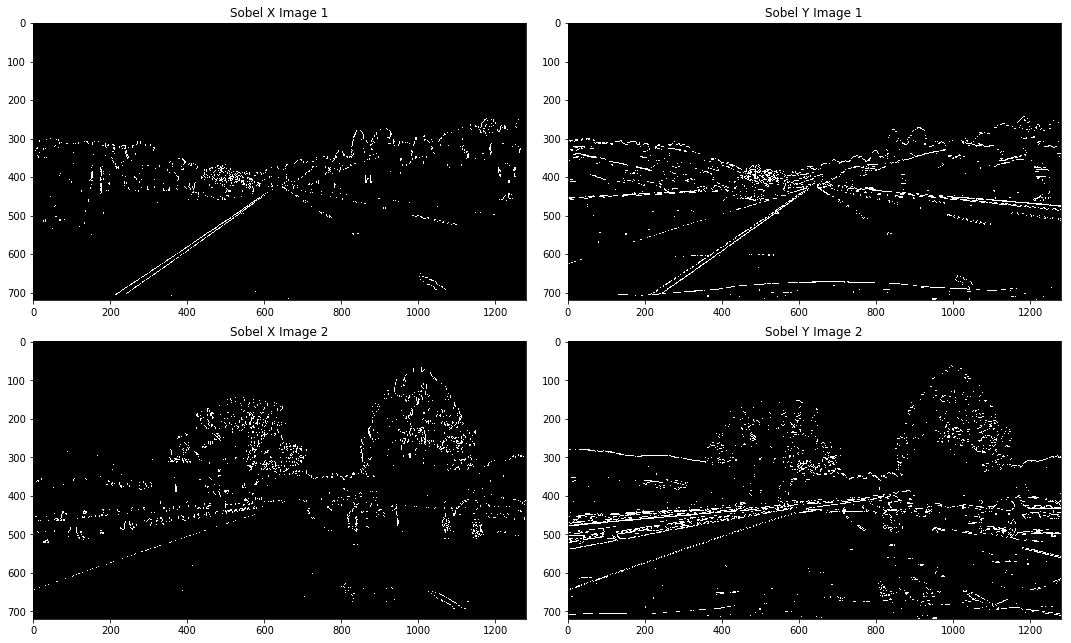

In [56]:
# read in lane images
lane_img_1 = cv2.imread('test_images/straight_lines1.jpg')
lane_img_2 = cv2.imread('test_images/test1.jpg')

# apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)

# create masked binary image (applying sobel filter along the x and y axis)
binary_scaled_sx_1 = abs_sobel_thresh(lane_img_1, orient='x', thresh_min=40, thresh_max=100)
binary_scaled_sx_2 = abs_sobel_thresh(lane_img_2, orient='x', thresh_min=40, thresh_max=100)
binary_scaled_sy_1 = abs_sobel_thresh(lane_img_1, orient='y', thresh_min=40, thresh_max=100)
binary_scaled_sy_2 = abs_sobel_thresh(lane_img_2, orient='y', thresh_min=40, thresh_max=100)

# plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_scaled_sx_1, cmap='gray')
ax1.set_title('Sobel X Image 1', fontsize=12)

ax2.imshow(binary_scaled_sy_1, cmap='gray')
ax2.set_title('Sobel Y Image 1', fontsize=12)

ax3.imshow(binary_scaled_sx_2, cmap='gray')
ax3.set_title('Sobel X Image 2', fontsize=12)

ax4.imshow(binary_scaled_sy_2, cmap='gray')
ax4.set_title('Sobel Y Image 2', fontsize=12)

# Save image for write up
#f.savefig("output_images/sobel_road_img_sample.png")

You can see from the images above that the Sobel X thresholding does a better job of detecting lines. This is because the x direction of the sobel funtions tends to emphisize vertical lines. 

Now I want to check on a few harder images to see how defined the lane lines become with Sobel thresholding

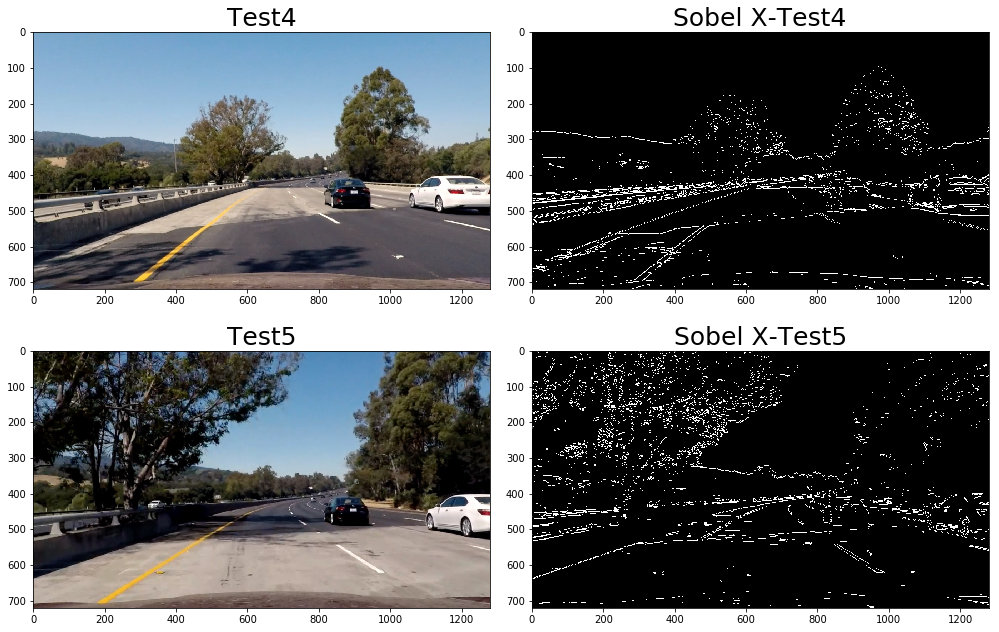

In [59]:
# read in lane images
lane_img_1 = mpimg.imread('test_images/test4.jpg')
lane_img_2 = mpimg.imread('test_images/test5.jpg')

# apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)

# Run the sobel function to create a masked binary image to the x and y axis separately                                                        
grad_binary_x_1 = abs_sobel_thresh(lane_img_1, orient='x', thresh_min=40, thresh_max=100\
)
grad_binary_y_1 = abs_sobel_thresh(lane_img_1, orient='y', thresh_min=40, thresh_max=100\
)
grad_binary_x_2 = abs_sobel_thresh(lane_img_2, orient='x', thresh_min=40, thresh_max=100\
)
grad_binary_y_2 = abs_sobel_thresh(lane_img_2, orient='y', thresh_min=40, thresh_max=100\
)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
f.tight_layout()

ax1.imshow(lane_img_1)
ax1.set_title('Test4', fontsize=25)
ax2.imshow(grad_binary_y_1, cmap='gray')
ax2.set_title('Sobel X-Test4', fontsize=25)

ax3.imshow(lane_img_2)
ax3.set_title('Test5', fontsize=25)
ax4.imshow(grad_binary_y_2, cmap='gray')
ax4.set_title('Sobel X-Test5', fontsize=25)


# Save image for write up
#f.savefig("output_images/sobel_road_img_harder_sample.png")

In the above example we can not see the yellow lines accuratly or fully through the images. Also the shadows and darker pavements are well defined in the Sobel threshold image. 

Next I will other thresholding techniques to further help identify lane lines. 

## Magnitude of the Gradient Thresholding

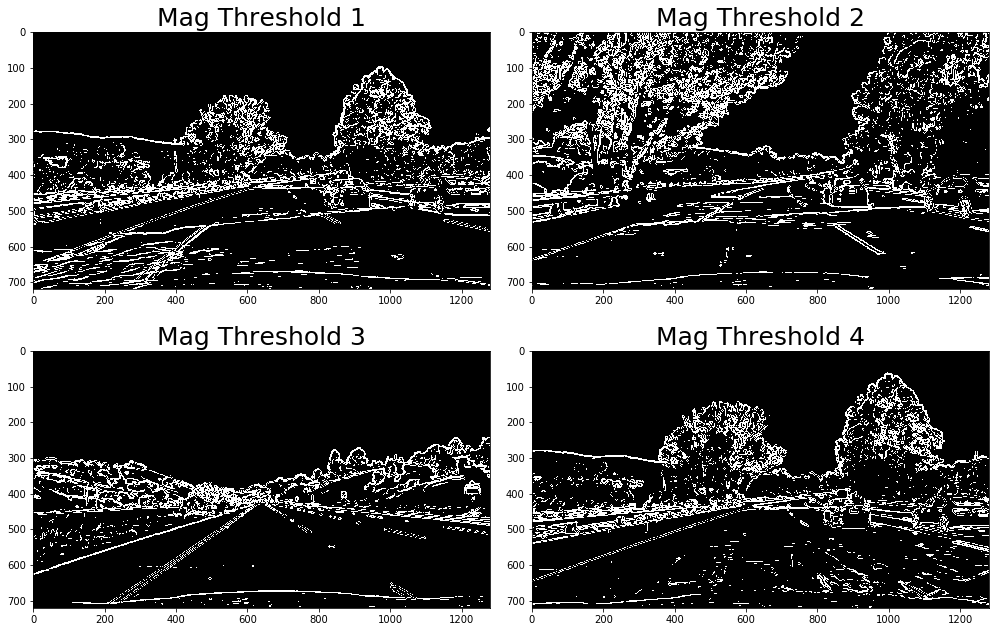

In [62]:
# Define Threshold
thresh = (30,100)

# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')
undistort_1 = cal_and_undistort(test4, objpoints, imgpoints)
undistort_2 = cal_and_undistort(test5, objpoints, imgpoints)
undistort_3 = cal_and_undistort(straight_lines1, objpoints, imgpoints)
undistort_4 = cal_and_undistort(test1, objpoints, imgpoints)

# Run the function                                                              
mag_binary_1 = magnitude_thresh(undistort_1, sobel_kernel=9, mag_thresh_input=thresh)
mag_binary_2 = magnitude_thresh(undistort_2, sobel_kernel=9, mag_thresh_input=thresh)
mag_binary_3 = magnitude_thresh(undistort_3, sobel_kernel=9, mag_thresh_input=thresh)
mag_binary_4 = magnitude_thresh(undistort_4, sobel_kernel=9, mag_thresh_input=thresh)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
f.tight_layout()

ax1.imshow(mag_binary_1, cmap='gray')
ax1.set_title('Mag Threshold 1', fontsize=25)
ax2.imshow(mag_binary_2, cmap='gray')
ax2.set_title('Mag Threshold 2', fontsize=25)

ax3.imshow(mag_binary_3, cmap='gray')
ax3.set_title('Mag Threshold 3', fontsize=25)
ax4.imshow(mag_binary_4, cmap='gray')
ax4.set_title('Mag Threshold 4', fontsize=25)


# Save image for write up
#f.savefig("output_images/mag_road_img_sample.png")

## Direction of the Gradient Thresholding

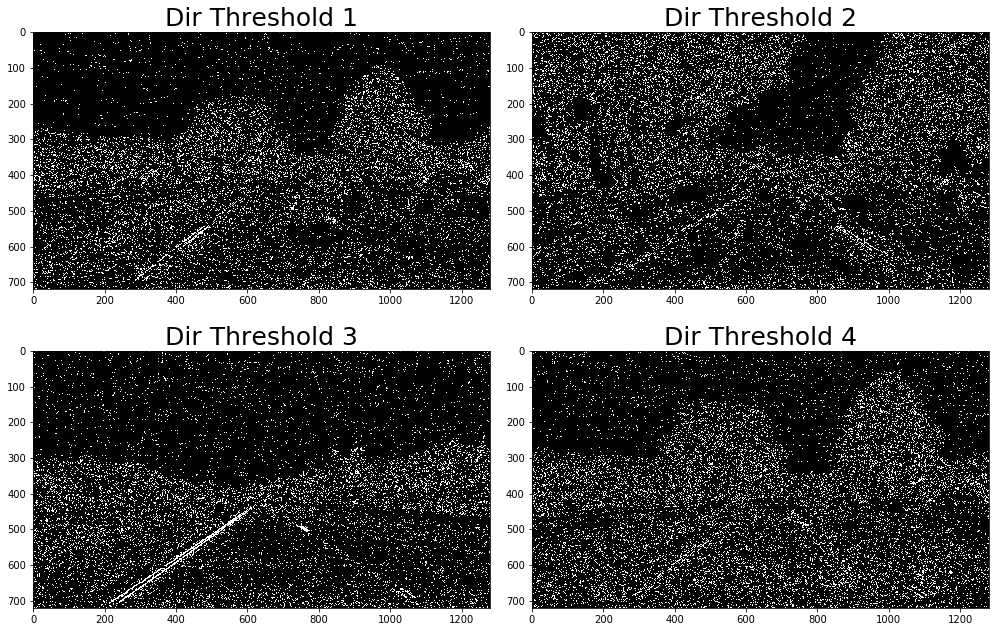

In [66]:
# Define Threshold
thresh = (0.8, 1.1) # (0.7, 1.3)
kernel = 3

# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')
undistort_1 = cal_and_undistort(test4, objpoints, imgpoints)
undistort_2 = cal_and_undistort(test5, objpoints, imgpoints)
undistort_3 = cal_and_undistort(straight_lines1, objpoints, imgpoints)
undistort_4 = cal_and_undistort(test1, objpoints, imgpoints)

# Run the function                                                              
dir_binary_1 = direction_thresh(undistort_1, sobel_kernel=kernel, dir_thresh_input=thresh)
dir_binary_2 = direction_thresh(undistort_2, sobel_kernel=kernel, dir_thresh_input=thresh)
dir_binary_3 = direction_thresh(undistort_3, sobel_kernel=kernel, dir_thresh_input=thresh)
dir_binary_4 = direction_thresh(undistort_4, sobel_kernel=kernel, dir_thresh_input=thresh)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
f.tight_layout()

ax1.imshow(dir_binary_1, cmap='gray')
ax1.set_title('Dir Threshold 1', fontsize=25)
ax2.imshow(dir_binary_2, cmap='gray')
ax2.set_title('Dir Threshold 2', fontsize=25)

ax3.imshow(dir_binary_3, cmap='gray')
ax3.set_title('Dir Threshold 3', fontsize=25)
ax4.imshow(dir_binary_4, cmap='gray')
ax4.set_title('Dir Threshold 4', fontsize=25)


# Save image for write up
#f.savefig("output_images/dir_road_img_sample_kernel3.png")

## Combined Thresholds

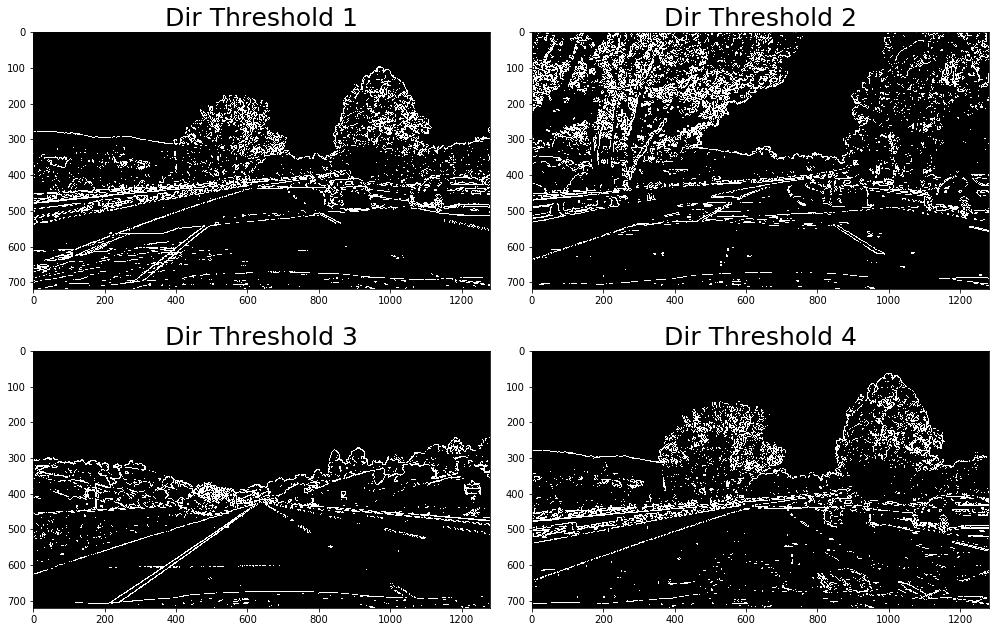

In [69]:
# Define Threshold
sobel_threshold = (40, 100)
mag_threshold = (30, 100)
dir_threshold = (0.8, 1.1) # (0.7, 1.3)

# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')
undistort_1 = cal_and_undistort(test4, objpoints, imgpoints)
undistort_2 = cal_and_undistort(test5, objpoints, imgpoints)
undistort_3 = cal_and_undistort(straight_lines1, objpoints, imgpoints)
undistort_4 = cal_and_undistort(test1, objpoints, imgpoints)

# Run the function                                                              
combined_binary_1 = combined_thresh(undistort_1, sobel_thresh=sobel_threshold, 
                                       mag_thresh=mag_threshold, dir_thresh=dir_threshold)
combined_binary_2 = combined_thresh(undistort_2, sobel_thresh=sobel_threshold, 
                                       mag_thresh=mag_threshold, dir_thresh=dir_threshold)
combined_binary_3 = combined_thresh(undistort_3, sobel_thresh=sobel_threshold, 
                                       mag_thresh=mag_threshold, dir_thresh=dir_threshold)
combined_binary_4 = combined_thresh(undistort_4, sobel_thresh=sobel_threshold, 
                                       mag_thresh=mag_threshold, dir_thresh=dir_threshold)


# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
f.tight_layout()

ax1.imshow(combined_binary_1, cmap='gray')
ax1.set_title('Dir Threshold 1', fontsize=25)
ax2.imshow(combined_binary_2, cmap='gray')
ax2.set_title('Dir Threshold 2', fontsize=25)

ax3.imshow(combined_binary_3, cmap='gray')
ax3.set_title('Dir Threshold 3', fontsize=25)
ax4.imshow(combined_binary_4, cmap='gray')
ax4.set_title('Dir Threshold 4', fontsize=25)


# Save image for write up
#f.savefig("output_images/combined_road_img_sample_.png")

## Combining above Thresholding with Color Thresholding

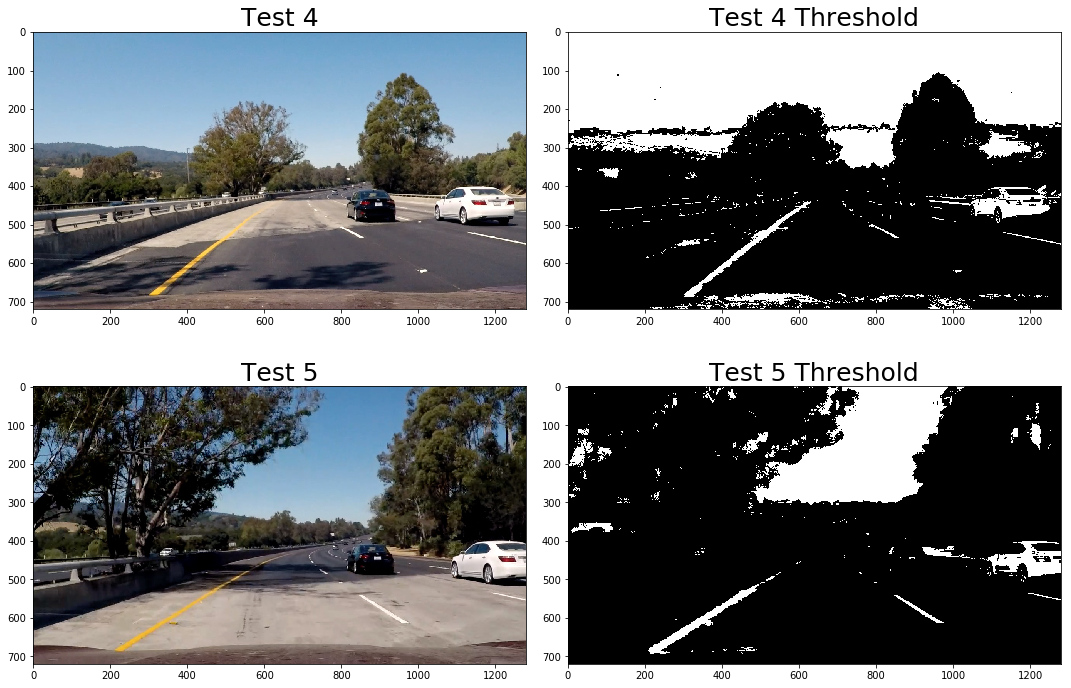

In [70]:
# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')

# Add cal and undistort

test4_threshold = color_thresh(test4)
test5_threshold = color_thresh(test5)
straight_lines1_threshold = color_thresh(straight_lines1)
test1_threshold = color_thresh(test1)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
f.tight_layout()

ax1.imshow(test4)
ax1.set_title('Test 4', fontsize=25)
ax2.imshow(test4_threshold, cmap='gray')
ax2.set_title('Test 4 Threshold', fontsize=25)

ax3.imshow(test5, cmap='gray')
ax3.set_title('Test 5', fontsize=25)
ax4.imshow(test5_threshold, cmap='gray')
ax4.set_title('Test 5 Threshold', fontsize=25)



# Save image for write up
#f.savefig("output_images/combined_color_road_img_sample_.png")

The Results above show that it is possible using the previously worked through thresholding applications to get both the yellow and white lines out of the image even in shadows and discolored road sections. 

## Perspective Transform

Convert image to show the "birds eye view" perspective of the lane lines

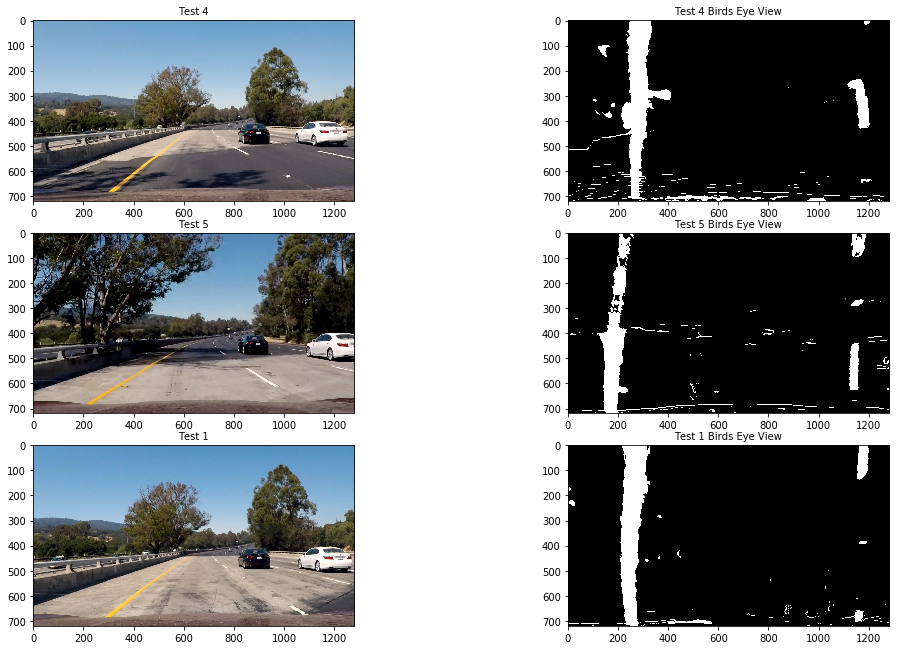

In [72]:
# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')

# Add cal and undistort

lane_img_1 = undistort_img(test4, mtx, dist)
lane_img_2 = undistort_img(test5, mtx, dist)
lane_img_3 = undistort_img(test1, mtx, dist)

# Masked binary image pipeline
test4_perspective = threshold_pipeline(transform_image(lane_img_1)[0])
test5_perspective = threshold_pipeline(transform_image(lane_img_2)[0])
test1_perspective = threshold_pipeline(transform_image(lane_img_3)[0])

# Plot and save images
f, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(test4)
ax1.set_title('Test 4', fontsize=10)
ax2.imshow(test4_perspective, cmap='gray')
ax2.set_title('Test 4 Birds Eye View', fontsize=10)

ax3.imshow(test5, cmap='gray')
ax3.set_title('Test 5', fontsize=10)
ax4.imshow(test5_perspective, cmap='gray')
ax4.set_title('Test 5 Birds Eye View', fontsize=10)

ax5.imshow(test1, cmap='gray')
ax5.set_title('Test 1', fontsize=10)
ax6.imshow(test1_perspective, cmap='gray')
ax6.set_title('Test 1 Birds Eye View', fontsize=10)

# Save image for write up
#f.savefig("output_images/perspective_transform_road_img_sample_.png")

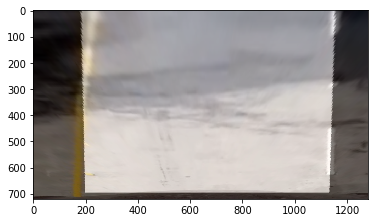

In [73]:


## use the transform and a polygon to figure out the right dimensions for source
testimg = lane_img_2.copy()

## create mask on which to plot polygon
mask = np.zeros_like(testimg)
poly = np.array([[(575,460),(720,460),(1075,685),(250,685)]], np.int32)

cv2.fillPoly(mask, poly, (255,)*3)

## create overlayed image
cv2.addWeighted(mask, 0.5, testimg, 0.5,0, testimg)

plt.imshow(transform_image(testimg)[0])



## Identify Lane line pixles

### Histogram 
Taking a histogram of the pixels in the perspective view image will give us probable lane lines at the peaks

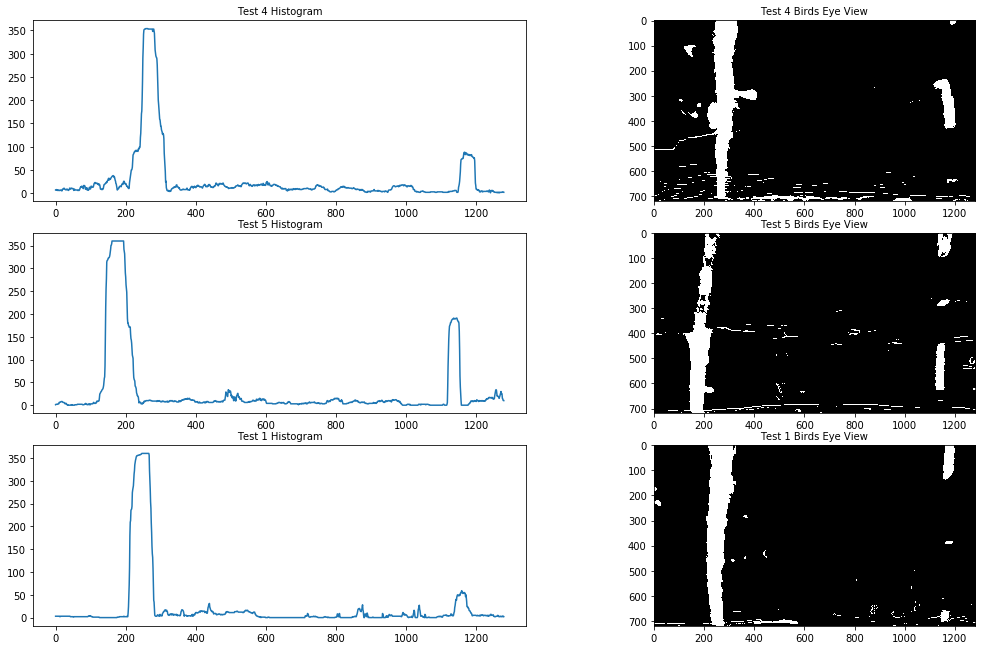

In [74]:
# Read in and undistort test images
straight_lines1 = mpimg.imread('test_images/straight_lines1.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')

# Add cal and undistort


lane_img_1 = undistort_img(test4, mtx, dist)
lane_img_2 = undistort_img(test5, mtx, dist)
lane_img_3 = undistort_img(test1, mtx, dist)

# Masked binary image pipeline
test4_perspective = threshold_pipeline(transform_image(lane_img_1)[0])
test5_perspective = threshold_pipeline(transform_image(lane_img_2)[0])
test1_perspective = threshold_pipeline(transform_image(lane_img_3)[0])

test4_hist = np.sum(test4_perspective[test4_perspective.shape[0]//2:,:], axis=0)
test5_hist = np.sum(test5_perspective[test5_perspective.shape[0]//2:,:], axis=0)
test1_hist = np.sum(test1_perspective[test1_perspective.shape[0]//2:,:], axis=0)

# Plot and save images
f, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(15, 9))
f.tight_layout()

ax1.plot(test4_hist)
ax1.set_title('Test 4 Histogram', fontsize=10)
ax2.imshow(test4_perspective, cmap='gray')
ax2.set_title('Test 4 Birds Eye View', fontsize=10)

ax3.plot(test5_hist)
ax3.set_title('Test 5 Histogram', fontsize=10)
ax4.imshow(test5_perspective, cmap='gray')
ax4.set_title('Test 5 Birds Eye View', fontsize=10)

ax5.plot(test1_hist)
ax5.set_title('Test 1 Histogram', fontsize=10)
ax6.imshow(test1_perspective, cmap='gray')
ax6.set_title('Test 1 Birds Eye View', fontsize=10)

# Save image for write up
#f.savefig("output_images/histogram_road_img_sample_.png")

The histogram shows an approximate area to look for lane lines in the image

### Sliding Window

Perform a sliding function of the most likely positions of the 2 lanes. This will also help us capture the curves of the lanes.

In [75]:
## function to create sliding window histogram
def sliding_window_hist(bin_img):
    
    ## set middle buffer to not consider
    mid_buffer = 175
    
    ## take a histogram of the bottom half of the image
    histogram = np.sum(bin_img[bin_img.shape[0]//3:,:], axis=0)

    ## find the peak of the left and right halves of the histogram
    ## these will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint-mid_buffer])
    rightx_base = np.argmax(histogram[midpoint+mid_buffer:]) + midpoint + mid_buffer

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 85
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    ## save rectangles
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_img.shape[0] - (window+1)*window_height
        win_y_high = bin_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save the windows on the visualization image
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

(720, 0)

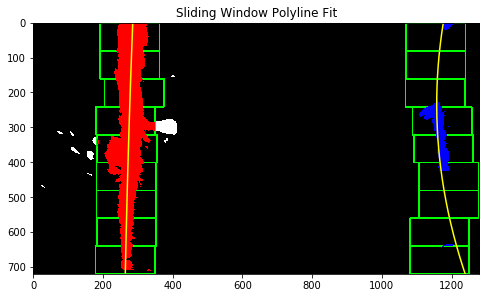

In [76]:


## image to test on
bin_img = binary_lane_img_2

## create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((bin_img, bin_img, bin_img))*255)

## extract sliding window data
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(bin_img)

## create polyfit lines
ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Draw the rectangles on image
for rect in rectangles:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 

nonzero = bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(8,12))
plt.imshow(out_img)
plt.title("Sliding Window Polyline Fit")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [77]:
# function for searching a subsequent frame of a video
def sliding_window_hist_next(bin_img, left_fit_prev, right_fit_prev):
    
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # area to search
    margin = 85

    # left and right lane pixels
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # only fit poly line if there are identified pixels
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

# radius and distance from center function
def curvature_dist(bin_img, left_lane_idx, right_lane_idx):
    
    # define range
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0])
    
    # max y
    y_eval = np.max(ploty)

    # find nonzero pixels
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx] 
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_curve = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_curve = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_radius = ((1 + (2*left_fit_curve[0]*y_eval*ym_per_pix + left_fit_curve[1])**2)**1.5) / np.absolute(2*left_fit_curve[0])
    right_radius = ((1 + (2*right_fit_curve[0]*y_eval*ym_per_pix + right_fit_curve[1])**2)**1.5) / np.absolute(2*right_fit_curve[0])
    
    # distance from center
    center_idx = bin_img.shape[1]//2
    identified_lanes_center_idx = (min(leftx) + max(rightx))//2
    
    dist_from_cent = np.abs(center_idx - identified_lanes_center_idx)*xm_per_pix
    
    return np.array([left_radius, right_radius, dist_from_cent])

# draw lane area
def fill_area(img, bin_img, left_fit_poly, right_fit_poly, inverse_matrix):
    
    # create copy of image
    img_copy = np.copy(cv2.resize(img, (1280, 720)))
    
    # define range
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # fit lines
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_matrix, (img_copy.shape[1], img_copy.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_copy, 1, newwarp, 0.3, 0)
    
    return result

# write info about curvature
def write_info(area_img, curvature_output):
    
    # copy area image
    area_img_copy = np.copy(area_img)
    
    # format text for overlay
    left_text = "Left Curve Radius: {0:.2f}m".format(curvature_output[0])
    right_text = "Right Curve Radius: {0:.2f}m".format(curvature_output[1])
    dist_text = "Distance from Center: {0:.2f}m".format(curvature_output[2])
    
    # area_img writing
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(area_img_copy, left_text, (60,90), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(area_img_copy, right_text, (60,140), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(area_img_copy, dist_text, (60,190), font, 1.25, (255,255,255), 2, cv2.LINE_AA)

    return area_img_copy

Test on sequential images

In [78]:
## read in lane images
lane_img_1 = cv2.imread('test_images/test6.jpg')
lane_img_2 = cv2.imread('test_images/test4.jpg')
lane_img_3 = cv2.imread('test_images/test5.jpg')

## resize images to be same size as the training images (so that calibration matrix references same areas)
binary_lane_img_1 = cv2.resize(lane_img_1, (1280, 720))
binary_lane_img_2 = cv2.resize(lane_img_2, (1280, 720))
binary_lane_img_3 = cv2.resize(lane_img_3, (1280, 720))

## apply distortion correction
binary_lane_img_1 = undistort_img(binary_lane_img_1, mtx, dist)
binary_lane_img_2 = undistort_img(binary_lane_img_2, mtx, dist)
binary_lane_img_3 = undistort_img(binary_lane_img_3, mtx, dist)

## create masked binary image using color threshold and transform image
binary_lane_img_1, M_1, Minv_1 = transform_image(binary_lane_img_1)
binary_lane_img_2, M_2, Minv_2 = transform_image(binary_lane_img_2)
binary_lane_img_3, M_3, Minv_3 = transform_image(binary_lane_img_3)

## apply threshold
binary_lane_img_1 = color_thresh(binary_lane_img_1)
binary_lane_img_2 = color_thresh(binary_lane_img_2)
binary_lane_img_3 = color_thresh(binary_lane_img_3)

## first find poly lines in first frame of sequence
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_lane_img_1)

left_fit_next, right_fit_next, left_lane_inds_next, right_lane_inds_next = sliding_window_hist_next(binary_lane_img_2, 
                                                                                                   left_fit, right_fit)


(720, 0)

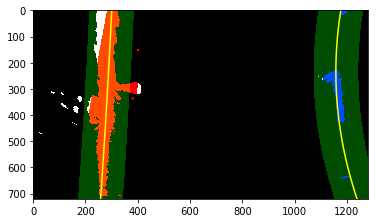

In [79]:
## visualize new fitted lines
# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((binary_lane_img_2, binary_lane_img_2, binary_lane_img_2))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_lane_img_2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds_next], nonzerox[left_lane_inds_next]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_next], nonzerox[right_lane_inds_next]] = [0, 0, 255]

## margin
margin = 85

## create fitted lines
ploty = np.linspace(0, binary_lane_img_2.shape[0]-1, binary_lane_img_2.shape[0] )
left_fitx_next = left_fit_next[0]*ploty**2 + left_fit_next[1]*ploty + left_fit_next[2]
right_fitx_next = right_fit_next[0]*ploty**2 + right_fit_next[1]*ploty + right_fit_next[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_next-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_next+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_next-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_next+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx_next, ploty, color='yellow')
plt.plot(right_fitx_next, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

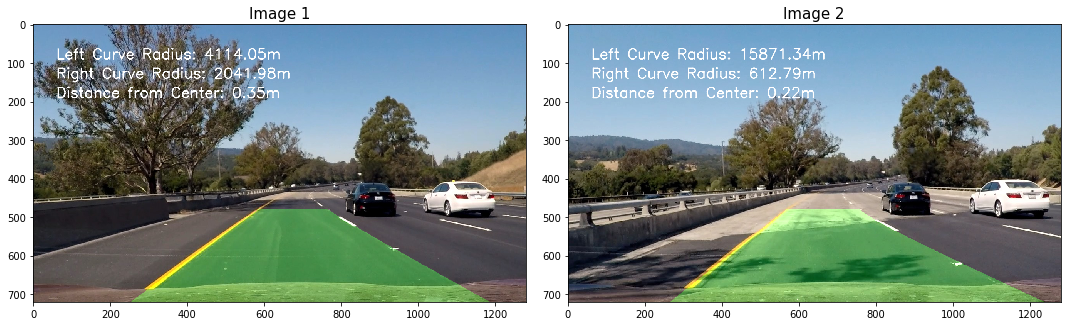

In [80]:
## read in lane images
lane_img_1 = cv2.imread('test_images/test6.jpg')
lane_img_2 = cv2.imread('test_images/test4.jpg')
lane_img_3 = cv2.imread('test_images/test5.jpg')

## resize images to be same size as the training images (so that calibration matrix references same areas)
binary_lane_img_1 = cv2.resize(lane_img_1, (1280, 720))
binary_lane_img_2 = cv2.resize(lane_img_2, (1280, 720))

## apply distortion correction
binary_lane_img_1 = undistort_img(binary_lane_img_1, mtx, dist)
binary_lane_img_2 = undistort_img(binary_lane_img_2, mtx, dist)

## create masked binary image using color threshold and transform image
binary_lane_img_1, M_1, Minv_1 = transform_image(binary_lane_img_1)
binary_lane_img_2, M_2, Minv_2 = transform_image(binary_lane_img_2)

## apply threshold
binary_lane_img_1 = color_thresh(binary_lane_img_1)
binary_lane_img_2 = color_thresh(binary_lane_img_2)

## first find poly lines in first frame of sequence
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_lane_img_1)
left_fit_2, right_fit_2, left_lane_inds_2, right_lane_inds_2, rectangles_2 = sliding_window_hist(binary_lane_img_2)

## draw lane area
new_img_1 = fill_area(lane_img_1, binary_lane_img_1, left_fit, right_fit, Minv_1)
new_img_2 = fill_area(lane_img_2, binary_lane_img_2, left_fit_2, right_fit_2, Minv_2)

## get curvature info
new_img_1_info = curvature_dist(binary_lane_img_1, left_lane_inds, right_lane_inds)
new_img_2_info = curvature_dist(binary_lane_img_2, left_lane_inds_2, right_lane_inds_2)

## write curvature details
new_img_1 = write_info(new_img_1, new_img_1_info)
new_img_2 = write_info(new_img_2, new_img_2_info)

## plot new image with filled area 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(new_img_1, cv2.COLOR_BGR2RGB))
ax1.set_title('Image 1', fontsize=15)

ax2.imshow(cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB))
ax2.set_title('Image 2', fontsize=15)

# Save image for write up
#f.savefig("output_images/curve_fitting_road_img_sample_.png")

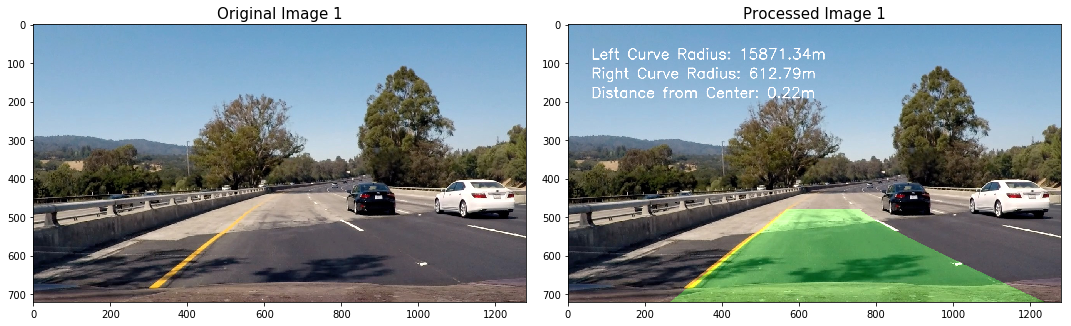

In [82]:
## read in lane images
ane_img_1 = cv2.imread('test_images/test6.jpg')
lane_img_2 = cv2.imread('test_images/test4.jpg')
lane_img_3 = cv2.imread('test_images/test5.jpg')

## resize images to be same size as the training images (so that calibration matrix references same areas)
binary_lane_img_1 = cv2.resize(lane_img_1, (1280, 720))
binary_lane_img_2 = cv2.resize(lane_img_2, (1280, 720))

## apply distortion correction
binary_lane_img_1 = undistort_img(binary_lane_img_1, mtx, dist)
binary_lane_img_2 = undistort_img(binary_lane_img_2, mtx, dist)

## create masked binary image using color threshold and transform image
binary_lane_img_1, M_1, Minv_1 = transform_image(binary_lane_img_1)
binary_lane_img_2, M_2, Minv_2 = transform_image(binary_lane_img_2)

## apply threshold
binary_lane_img_1 = color_thresh(binary_lane_img_1)
binary_lane_img_2 = color_thresh(binary_lane_img_2)

## first find poly lines in first frame of sequence
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_lane_img_1)
left_fit_2, right_fit_2, left_lane_inds_2, right_lane_inds_2, rectangles_2 = sliding_window_hist(binary_lane_img_2)

## draw lane area
new_img_1 = fill_area(lane_img_1, binary_lane_img_1, left_fit, right_fit, Minv_1)
new_img_2 = fill_area(lane_img_2, binary_lane_img_2, left_fit_2, right_fit_2, Minv_2)

## get curvature info
new_img_1_info = curvature_dist(binary_lane_img_1, left_lane_inds, right_lane_inds)
new_img_2_info = curvature_dist(binary_lane_img_2, left_lane_inds_2, right_lane_inds_2)

## write curvature details
new_img_1 = write_info(new_img_1, new_img_1_info)
new_img_2 = write_info(new_img_2, new_img_2_info)

## plot new image with filled area 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(lane_img_2, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image 1', fontsize=15)

ax2.imshow(cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB))
ax2.set_title('Processed Image 1', fontsize=15)

# Save image for write up
#f.savefig("output_images/curve_fitting_road_img_sample_2_.png")

In [83]:
## class for lane detector
class Lane_detector:
    
    ## initialize variables
    def __init__(self, frames_to_keep=10):
        
        # was the line detected in the last iteration?
        self.detected_left = False
        self.detected_right = False
        
        # x values of the last n fits of the line
        self.recent_xfitted_left = deque(maxlen=frames_to_keep)
        self.recent_xfitted_right = deque(maxlen=frames_to_keep)
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None  
        self.best_fit_right = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit_left = None
        self.current_fit_right = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature_left = None
        self.radius_of_curvature_right = None 

        #detected line pixels
        self.left_lane_idx = deque(maxlen=frames_to_keep)
        self.right_lane_idx = deque(maxlen=frames_to_keep)
        
        #curvature info
        self.curvature = None
        self.curve_good = None
        
        self.fit_change_hist = []
        self.curve_change_hist = []
        
    ## check to see if magnitude of difference is acceptable
    def sanity_check_fit(self, coef_prev, coef):
        
        ## calculate absolute change
        change = np.abs((coef_prev - coef)/coef_prev)
        
        self.fit_change_hist.append(change)
        
        if not all([(change[0] < 18.5),(change[1] < 1295),(change[2] < 0.85)]):
            print("fit change",change)
                        
        return all([(change[0] < 18.5),(change[1] < 1295),(change[2] < 0.85)])
            
    ## sanity check for curvature
    def sanity_check_curve(self, curve_prev, curve):
        
        ## calculate absolute change
        change = np.abs((curve_prev - curve)/curve_prev)
        
        self.curve_change_hist.append(change)
        
        if not all([(change[0] < 25.01),(change[1] < 25.28)]):
            print("curve change",change)

        return all([(change[0] < 25.01),(change[1] < 25.28)])
    
    ## pipeline
    def pipeline(self, img, mtx=mtx, dist=dist):

        ## resize images to be same size as the training images (so that calibration matrix references same areas)
        binary_img = cv2.resize(img, (1280, 720))

        ## apply distortion correction
        binary_img = undistort_img(binary_img, mtx, dist)

        ## create masked binary image using color threshold and transform image
        binary_img, M, Minv = transform_image(binary_img)

        ## apply threshold
        binary_img = color_thresh(binary_img)
                
        ## calculate fit
#         if (self.detected_left) and (self.detected_right):
            
#             try:
#                 ## use previous bounds if previous success
#                 left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_hist_next(binary_img, 
#                                                                                             self.current_fit_left,
#                                                                                             self.current_fit_right)
#             except UnboundLocalError as e:
#                 try:
#                     ## first find poly lines in first frame of sequence
#                     left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_img)
#                 except TypeError as e:
#                     left_fit = None
#                     right_fit = None 
#                     left_lane_inds = None
#                     right_lane_inds = None  
        
#         else:
            
        try:
            ## first find poly lines in first frame of sequence
            left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_img)
        except TypeError as e:
            left_fit = None
            right_fit = None 
            left_lane_inds = None
            right_lane_inds = None
                

        ## get curvature info
        if (left_fit is not None) and (right_fit is not None):
            try:
                new_img_1_info = curvature_dist(binary_img, left_lane_inds, right_lane_inds)
                if self.curve_good is None:
                    self.curvature = new_img_1_info
                    self.curve_good = True
                elif self.sanity_check_curve(self.curvature, new_img_1_info):
                    self.curvature = new_img_1_info
                    self.curve_good = True
                else:
                    self.curve_good = False
            except:
                new_img_1_info = self.curvature
                self.curve_good = False
        else:
            new_img_1_info = self.curvature
            self.curve_good = False
        

        ## store left lane if fit is available
        if ((left_fit is not None) and (len(left_lane_inds) != 0)):
            if self.current_fit_left is None:
                self.detected_left = True
                self.recent_xfitted_left.append(left_fit)
                self.current_fit_left = left_fit
                self.best_fit_left = left_fit
                self.left_lane_idx.append(left_lane_inds)
            elif ((self.sanity_check_fit(self.current_fit_left,left_fit)) and (self.curve_good)):
                self.detected_left = True
                self.recent_xfitted_left.append(left_fit)
                self.current_fit_left = left_fit
                self.best_fit_left = np.average(self.recent_xfitted_left, axis=0)
                self.left_lane_idx.append(left_lane_inds)
            else:
                print("left - didnt pass san. check")
                self.detected_left = False
        elif left_fit is None:
            self.detected_left = False
            
        ## store right lane if fit is available
        if ((right_fit is not None) and (len(right_lane_inds) != 0)):
            if self.current_fit_right is None:
                self.detected_right = True
                self.recent_xfitted_right.append(right_fit)
                self.current_fit_right = right_fit
                self.best_fit_right = right_fit
                self.right_lane_idx.append(right_lane_inds)
            elif ((self.sanity_check_fit(self.current_fit_right,right_fit)) and (self.curve_good)):
                self.detected_right = True
                self.recent_xfitted_right.append(right_fit)
                self.current_fit_right = right_fit
                self.best_fit_right = np.average(self.recent_xfitted_right, axis=0)
                self.right_lane_idx.append(right_lane_inds)
            else:
                print("right - didnt pass san. check")
                self.detected_right = False
        elif right_fit is None:
            self.detected_right = False
            
        if (self.detected_left and self.detected_right) or ((self.best_fit_left is not None) and 
                                                            (self.best_fit_right is not None)):


            ## draw lane area
            new_img_1 = fill_area(img, binary_img, self.best_fit_left, self.best_fit_right, Minv)

            ## write curvature details
            new_img_1 = write_info(new_img_1, new_img_1_info)
            
            return new_img_1
        
        else:
            return img


In [37]:


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [38]:
## create detector object
detector = Lane_detector()

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(detector.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  1%|          | 10/1261 [00:01<02:28,  8.40it/s]

curve change [  1.42913592e-02   3.90103023e+01   3.63636364e-02]
left - didnt pass san. check
right - didnt pass san. check


  1%|          | 14/1261 [00:01<02:26,  8.50it/s]

fit change [ 31.17640602   1.16226043   0.03471986]
right - didnt pass san. check
fit change [ 21.83793357   0.91478689   0.03249174]
right - didnt pass san. check


  3%|▎         | 35/1261 [00:04<02:27,  8.34it/s]

curve change [  0.08886848  40.91081742   0.05769231]
left - didnt pass san. check
right - didnt pass san. check
curve change [  3.37210753e-02   4.14483196e+01   3.84615385e-02]
left - didnt pass san. check
right - didnt pass san. check


  7%|▋         | 89/1261 [00:11<02:34,  7.57it/s]

fit change [  1.97458250e+01   4.31029476e-01   1.78067873e-02]
right - didnt pass san. check
fit change [ 25.57284842   0.59995494   0.02670719]
right - didnt pass san. check


  7%|▋         | 91/1261 [00:11<02:30,  7.76it/s]

fit change [ 30.97707012   0.8323174    0.04263425]
right - didnt pass san. check
fit change [ 28.32376232   0.74337456   0.03548205]
right - didnt pass san. check


  7%|▋         | 93/1261 [00:11<02:31,  7.68it/s]

fit change [ 25.32817268   0.67235735   0.03267902]
right - didnt pass san. check
fit change [ 23.29433789   0.65928286   0.03640242]
right - didnt pass san. check


  9%|▉         | 115/1261 [00:14<02:29,  7.68it/s]

fit change [ 38.09550439   1.36939471   0.04391421]
right - didnt pass san. check


 17%|█▋        | 216/1261 [00:28<02:52,  6.06it/s]

curve change [  2.30468837e-01   1.63754538e+03   5.83333333e-01]
left - didnt pass san. check
right - didnt pass san. check


 23%|██▎       | 286/1261 [00:37<02:13,  7.32it/s]

curve change [  3.15916939e-01   1.41426529e+02   1.11111111e-01]
left - didnt pass san. check
right - didnt pass san. check


 24%|██▍       | 308/1261 [00:40<02:06,  7.53it/s]

curve change [  0.10996422  25.7689275    0.05128205]
left - didnt pass san. check
right - didnt pass san. check


 25%|██▍       | 314/1261 [00:41<02:11,  7.21it/s]

curve change [  2.11197407e+02   6.25933699e-01   1.88679245e-02]
left - didnt pass san. check
right - didnt pass san. check


 30%|███       | 383/1261 [00:50<01:55,  7.58it/s]

curve change [  2.23854689e-01   5.18256568e+01   1.58730159e-02]
left - didnt pass san. check
right - didnt pass san. check


 31%|███       | 391/1261 [00:51<02:01,  7.19it/s]

fit change [  1.96713114e+01   6.81724955e-01   8.38683638e-03]
right - didnt pass san. check
fit change [  3.01481141e+01   1.13859218e+00   1.35355825e-02]
right - didnt pass san. check


 31%|███       | 393/1261 [00:52<02:01,  7.12it/s]

fit change [  3.22039880e+01   1.39037368e+00   1.94673633e-02]
right - didnt pass san. check
fit change [  1.97813178e+01   1.37853098e+01   1.91801528e-02]
left - didnt pass san. check
fit change [  3.11335782e+01   1.39264880e+00   1.56094483e-02]
right - didnt pass san. check


 31%|███▏      | 395/1261 [00:52<01:58,  7.29it/s]

fit change [  5.51385536e+01   2.95652095e+01   1.34007887e-02]
left - didnt pass san. check
fit change [  5.00294504e+01   2.47397608e+00   3.68295624e-02]
right - didnt pass san. check
fit change [  8.14399645e+01   4.65692531e+01   2.53259060e-02]
left - didnt pass san. check


 31%|███▏      | 397/1261 [00:52<01:53,  7.64it/s]

fit change [  7.98033675e+01   4.46794744e+01   1.79933071e-02]
left - didnt pass san. check
fit change [  6.65168587e+01   3.44758577e+01   4.21436015e-04]
left - didnt pass san. check


 32%|███▏      | 399/1261 [00:52<01:54,  7.53it/s]

fit change [  3.58434984e+01   1.88924281e+01   1.09959170e-02]
left - didnt pass san. check


 33%|███▎      | 414/1261 [00:55<01:54,  7.41it/s]

fit change [  2.31328998e+01   1.03454861e-01   1.42536195e-03]
right - didnt pass san. check
fit change [  2.23678428e+01   1.19273634e-01   2.24660649e-03]
right - didnt pass san. check


 34%|███▍      | 435/1261 [00:58<01:52,  7.32it/s]

curve change [ 32.95746954   1.63245052   0.07692308]
left - didnt pass san. check
right - didnt pass san. check


 35%|███▌      | 445/1261 [00:59<01:47,  7.59it/s]

curve change [  1.59501917e-02   3.48906026e+01   1.87500000e-01]
left - didnt pass san. check
right - didnt pass san. check
curve change [  4.37925082e-02   4.43125728e+01   4.37500000e-01]
left - didnt pass san. check
right - didnt pass san. check


 36%|███▌      | 450/1261 [01:00<01:49,  7.43it/s]

fit change [  1.47369779e+02   2.66548507e+00   2.79539510e-02]
right - didnt pass san. check
fit change [  1.36844476e+02   2.73904199e+00   3.09451571e-02]
right - didnt pass san. check


 36%|███▌      | 452/1261 [01:00<01:52,  7.20it/s]

fit change [  1.08515539e+02   2.42046942e+00   3.13379250e-02]
right - didnt pass san. check
fit change [  1.22426724e+02   2.88161783e+00   3.89578573e-02]
right - didnt pass san. check


 36%|███▌      | 454/1261 [01:00<01:53,  7.13it/s]

fit change [  7.34557407e+01   1.95679518e+00   3.07969801e-02]
right - didnt pass san. check
fit change [  1.28567447e+02   3.53926807e+00   5.40845500e-02]
right - didnt pass san. check


 36%|███▌      | 456/1261 [01:01<01:53,  7.11it/s]

curve change [  5.25686034e-02   6.84400701e+01   4.34782609e-02]
left - didnt pass san. check
right - didnt pass san. check


 36%|███▋      | 458/1261 [01:01<01:53,  7.06it/s]

curve change [  1.71188029e-01   9.62304843e+02   4.16666667e-02]
left - didnt pass san. check
right - didnt pass san. check


 40%|████      | 505/1261 [01:07<01:35,  7.88it/s]

curve change [  0.30523753  29.44789533   0.88888889]
left - didnt pass san. check
right - didnt pass san. check


 41%|████      | 514/1261 [01:08<01:42,  7.32it/s]

curve change [   0.45493685  224.5226222     0.        ]
left - didnt pass san. check
right - didnt pass san. check


 44%|████▍     | 554/1261 [01:14<01:39,  7.08it/s]

curve change [  8.09677495e+00   1.00502910e+03   4.50000000e-01]
left - didnt pass san. check
right - didnt pass san. check


 45%|████▍     | 565/1261 [01:15<01:39,  7.01it/s]

curve change [ 30.61481626   0.69624095   0.16666667]
left - didnt pass san. check
right - didnt pass san. check


 46%|████▌     | 582/1261 [01:18<01:35,  7.08it/s]

fit change [  3.62296376e+01   2.90644329e+00   2.34699499e-02]
right - didnt pass san. check
fit change [  2.23482283e+01   1.92190084e+00   1.68280885e-02]
right - didnt pass san. check


 48%|████▊     | 606/1261 [01:21<01:31,  7.15it/s]

fit change [  4.82218887e+01   5.66878444e+00   5.19480453e-03]
right - didnt pass san. check
fit change [  8.91572930e+01   1.10990051e+01   1.11376502e-02]
right - didnt pass san. check


 48%|████▊     | 608/1261 [01:21<01:35,  6.86it/s]

fit change [  6.29462590e+01   5.02463414e+00   2.71703861e-02]
right - didnt pass san. check
fit change [  6.59835075e+01   7.46323453e+00   2.04867699e-02]
right - didnt pass san. check


 48%|████▊     | 610/1261 [01:22<01:30,  7.16it/s]

fit change [  3.68652862e+01   1.81981818e+00   2.93732697e-02]
right - didnt pass san. check
fit change [ 23.32154159  13.1561296    0.05754673]
right - didnt pass san. check


 49%|████▊     | 612/1261 [01:22<01:33,  6.96it/s]

fit change [  3.90010092e+01   1.83454296e+00   3.44114601e-02]
right - didnt pass san. check
fit change [  5.01693668e+01   3.21080216e+00   3.80507690e-02]
right - didnt pass san. check


 49%|████▊     | 614/1261 [01:22<01:31,  7.05it/s]

fit change [  1.68623965e+02   1.72592019e+01   3.45928377e-02]
right - didnt pass san. check
fit change [  1.56063896e+02   1.76592437e+01   3.55249864e-02]
right - didnt pass san. check


 49%|████▉     | 616/1261 [01:23<01:31,  7.04it/s]

fit change [  1.49111920e+02   1.96544936e+01   2.96304804e-02]
right - didnt pass san. check
fit change [  1.42964370e+02   1.98549498e+01   3.15676891e-02]
right - didnt pass san. check


 49%|████▉     | 618/1261 [01:23<01:29,  7.19it/s]

fit change [  1.87945638e+02   2.60999505e+01   2.79104279e-02]
right - didnt pass san. check
fit change [  2.06760035e+02   3.24362412e+01   1.71233146e-02]
right - didnt pass san. check


 49%|████▉     | 620/1261 [01:23<01:25,  7.48it/s]

fit change [  2.01032854e+02   3.33029331e+01   1.88182672e-02]
right - didnt pass san. check
fit change [  1.94060835e+02   3.63036415e+01   6.94098454e-03]
right - didnt pass san. check


 49%|████▉     | 622/1261 [01:23<01:24,  7.54it/s]

fit change [  2.11847123e+02   4.19525165e+01   3.65069926e-03]
right - didnt pass san. check
fit change [  4.33855839e+01   1.46552408e+01   1.91132812e-02]
right - didnt pass san. check


 49%|████▉     | 624/1261 [01:24<01:22,  7.71it/s]

fit change [  4.16749685e+01   1.53547315e+01   1.09405775e-02]
right - didnt pass san. check
fit change [  4.67106042e+01   1.72696342e+01   4.10800684e-03]
right - didnt pass san. check


 50%|████▉     | 626/1261 [01:24<01:27,  7.23it/s]

fit change [  5.45681287e+01   1.53552180e+01   1.73868890e-02]
right - didnt pass san. check
fit change [  3.66399754e+01   1.39112933e+01   1.16831520e-02]
right - didnt pass san. check


 50%|████▉     | 628/1261 [01:24<01:26,  7.34it/s]

fit change [  4.55545283e+01   1.58302530e+01   6.50886276e-03]
right - didnt pass san. check
fit change [  2.81207170e+01   1.14090611e+01   1.52126327e-02]
right - didnt pass san. check


 50%|████▉     | 630/1261 [01:24<01:26,  7.29it/s]

fit change [  1.87047010e+02   3.20331588e+01   1.05360397e-02]
right - didnt pass san. check
fit change [  1.69103723e+02   3.41092648e+01   3.27854511e-02]
right - didnt pass san. check


 50%|█████     | 632/1261 [01:25<01:31,  6.88it/s]

fit change [  1.53284530e+02   3.58185991e+01   4.94864123e-02]
right - didnt pass san. check
fit change [  1.48268763e+02   3.77951074e+01   6.04341585e-02]
right - didnt pass san. check


 50%|█████     | 634/1261 [01:25<01:31,  6.85it/s]

fit change [  1.45722859e+02   3.95281630e+01   6.41493266e-02]
right - didnt pass san. check
fit change [  1.80097974e+02   4.53362145e+01   6.58543133e-02]
right - didnt pass san. check


 63%|██████▎   | 794/1261 [01:47<01:11,  6.49it/s]

curve change [  1.29607388e-01   9.99610481e+01   9.09090909e-02]
left - didnt pass san. check
right - didnt pass san. check


 78%|███████▊  | 988/1261 [02:14<00:38,  7.07it/s]

curve change [  3.41748309e+02   3.64587598e-01   1.73913043e-01]
left - didnt pass san. check
right - didnt pass san. check


 88%|████████▊ | 1105/1261 [02:33<00:23,  6.61it/s]

curve change [  2.29531068e+02   1.22983328e+00   1.94174757e-02]
left - didnt pass san. check
right - didnt pass san. check


 88%|████████▊ | 1108/1261 [02:33<00:22,  6.69it/s]

curve change [  8.59991538e+01   8.76776021e-01   7.52688172e-02]
left - didnt pass san. check
right - didnt pass san. check


 94%|█████████▍| 1187/1261 [02:44<00:10,  6.86it/s]

fit change [  3.81430055e+01   1.69720983e+00   1.43855307e-02]
right - didnt pass san. check
fit change [  4.42144785e+01   2.07612322e+00   1.62113746e-02]
right - didnt pass san. check


 94%|█████████▍| 1189/1261 [02:45<00:10,  7.07it/s]

fit change [  4.10265830e+01   2.04712284e+00   1.54103997e-02]
right - didnt pass san. check
fit change [  4.15898078e+01   2.37435430e+00   2.32149233e-02]
right - didnt pass san. check


 94%|█████████▍| 1191/1261 [02:45<00:09,  7.31it/s]

fit change [  4.60488004e+01   2.61459471e+00   2.08545820e-02]
right - didnt pass san. check
fit change [  3.03417630e+01   1.91277791e+00   1.62109642e-02]
right - didnt pass san. check


 95%|█████████▍| 1193/1261 [02:45<00:09,  6.86it/s]

fit change [  2.47755952e+01   1.33148163e+00   5.17275738e-03]
right - didnt pass san. check
fit change [  2.66768194e+01   1.30404667e+00   1.28538927e-04]
right - didnt pass san. check


 95%|█████████▍| 1195/1261 [02:45<00:09,  7.21it/s]

fit change [  2.37400126e+01   1.29752786e+00   5.30560425e-03]
right - didnt pass san. check
fit change [  2.50984745e+01   1.26174165e+00   3.34013980e-04]
right - didnt pass san. check


 95%|█████████▍| 1197/1261 [02:46<00:09,  6.76it/s]

fit change [  2.27465802e+01   1.12144923e+00   3.55267770e-03]
right - didnt pass san. check
fit change [  1.98159410e+01   1.03128735e+00   8.44002526e-04]
right - didnt pass san. check


 95%|█████████▌| 1199/1261 [02:46<00:08,  7.10it/s]

curve change [  4.13736932e-02   1.38700772e+02   1.83486239e-02]
left - didnt pass san. check
right - didnt pass san. check


100%|█████████▉| 1260/1261 [02:55<00:00,  7.21it/s]


fit change [  4.88218405e+01   4.73856783e+00   1.04387486e-03]
left - didnt pass san. check
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 28s, sys: 2.44 s, total: 4min 30s
Wall time: 2min 57s


In [40]:
import os
images_list = os.listdir('test_images/')

## generate processed version of each image
for idx_path in images_list:
    if idx_path != ".DS_Store":
        image_to_process = cv2.imread("test_images/" + idx_path)
        detector = Lane_detector()
        processed_image = detector.pipeline(image_to_process)
        cv2.imwrite("test_images/"+idx_path[:-4]+"_processed.jpg",processed_image)
